### STATS 202 
Waseh Ahmad
Summer 2019

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [77]:
#import statements
# import matplotlib.pyplot as plt
# from matplotlib.colors import Colormap
import random
import matplotlib
# matplotlib.use('Agg') # set the backend before importing pyplot

import matplotlib.pyplot as plt # etc. etc.

from matplotlib.colors import Colormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
import sklearn
from bayes_opt import BayesianOptimization
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate, GridSearchCV, GroupKFold
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report,log_loss
import xgboost as xgb
import patsy
import library
from mpl_toolkits.mplot3d import Axes3D

#panel data
from linearmodels import PanelOLS


warnings.filterwarnings('ignore')

### Load Data and variables

In [3]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
    
allTrialsDF = pd.concat(trials)

#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"


#Create dummy variables for Study
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]
#drop UK explictly instead of first
countryDummies = pd.get_dummies(allTrialsDF.Country,prefix='Country').drop(['Country_UK'],axis=1)
studyDummies = pd.get_dummies(allTrialsDF.Study,drop_first=True,prefix='Study')
# allTrialsDF = allTrialsDF.drop(['Country','Study'],axis=1)

allTrialsDF = pd.concat([allTrialsDF,countryDummies,studyDummies],axis=1)

#change lead status to binary values
factors = {'Passed': 0, 'Flagged': 1,'Assign to CS':1}
allTrialsDF['LeadStatus'].replace(factors,inplace = True)

In [114]:
# add variables for lag, diff, sums of (p,n,g)

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)

# Add relative visit day variable
for name,group in allSortedDF.groupby('PatientID').__iter__():
    idx = 0
    for row_index,row in group.iterrows():
        allSortedDF.at[row_index,'RelativeVisitDay'] = idx
        idx+=1

#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff()

#get first lags for PANSS, Ps, Gs, Ns
for col in ['Ps','Ns','Gs','PANSS_Total','PANSS_Total_diff_1']:
    newCol = col+"_lag_1"
    allSortedDF[newCol] = allSortedDF.groupby('PatientID')[col].shift(1)
    
# #fill na for lags
# allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
# # let values of nan for lag of diff (occurs when visit day= 0), equal 0
# allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1'].fillna(0)
# allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1'].fillna(allSortedDF.Gs)
# allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1'].fillna(allSortedDF.Ns)
# allSortedDF['Ps_lag_1'] = allSortedDF['Ps_lag_1'].fillna(allSortedDF.Ns)

### Treatment effect

In [111]:
hypotDF = allSortedDF
hypotDF['PatientID'] = pd.Categorical(hypotDF['PatientID'])
# type(hypotDF['PatientID'][20])

formula = "PANSS_Total ~ TxGroup:VisitDay + VisitDay + PatientID"
olsModel = smf.ols(formula,data=allSortedDF).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     20.56
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:59:58   Log-Likelihood:                -83865.
No. Observations:               22909   AIC:                         1.736e+05
Df Residuals:                   19960   BIC:                         1.973e+05
Df Model:                        2948                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             90.4094      3.811     23.725      0.000      82.940      97.879
PatientID[T.10002]    -1.8619      6.957     -0.268      0.789     -15.499      11.775
PatientID[T.10003]    25.7272      5.609      4.587      0.000      14.733      36.722
PatientID[T.10004]    -7.2857      5.218     -1.396      0.163     -17.514       2.942
PatientID[T.10005]    -6.4426      5.081     -1.268      0.205     -16.401       3.516
PatientID[T.10006]    -8.1349      5.081     -1.601      0.109     -18.094       1.825
PatientID[T.10007]    30.9825      6.319      4.903      0.000      18.596      43.369
PatientID[T.10008]    -1.7225      5.389     -0.320      0.749     -12.286       8.841
PatientID[T.10009]    31.1094      6.319      4.923      0.000      18.723      43.496
PatientID[T.10010]    19.0354      6.957      2.736      0.006       5.399      32.672
PatientID[T.10011]     8.6715      5.081      1.707      0.088      -1.287      18.630
PatientID[T.10012]    10.4331      5.903      1.767      0.077      -1.138      22.004
PatientID[T.10013]   -23.9753      5.081     -4.718      0.000     -33.935     -14.016
PatientID[T.10014]    31.6347      5.081      6.226      0.000      21.676      41.594
PatientID[T.10015]    12.5668      6.957      1.806      0.071      -1.070      26.204
PatientID[T.10016]    19.7552      5.609      3.522      0.000       8.761      30.749
PatientID[T.10017]    -5.2477      5.081     -1.033      0.302     -15.207       4.712
PatientID[T.10018]     8.3720      5.609      1.493      0.136      -2.623      19.366
PatientID[T.10019]     0.4294      5.081      0.085      0.933      -9.529      10.388
PatientID[T.10020]     3.6282      5.609      0.647      0.518      -7.366      14.623
PatientID[T.10021]   -11.0752      5.081     -2.180      0.029     -21.035      -1.116
PatientID[T.10022]     4.2385      5.081      0.834      0.404      -5.720      14.197
PatientID[T.10023]    17.5041      6.957      2.516      0.012       3.867      31.141
PatientID[T.10024]    10.5747      5.081      2.081      0.037       0.616      20.534
PatientID[T.10025]     5.8788      5.609      1.048      0.295      -5.115      16.873
PatientID[T.10026]    11.0909      5.218      2.126      0.034       0.863      21.318
PatientID[T.10027]    18.1715      5.903      3.078      0.002       6.600      29.743
PatientID[T.10028]   -16.2200      5.218     -3.109      0.002     -26.447      -5.993
PatientID[T.10029]   -10.0611      5.218     -1.928      0.054     -20.289       0.167
PatientID[T.10030]     5.4549      6.957      0.784      0.433      -8.182      19.092
PatientID[T.10031]    10.4831      6.319      1.659      0.097      -1.903      22.869
PatientID[T.10032]    18.7974      5.903      3.184      0.001       7.226      30.369
PatientID[T.10033]    -1.7214      5.0

In [110]:
olsModel.pvalues.loc[olsModel.pvalues <0.05]

Intercept             4.649116e-02
PatientID[T.10007]    5.740500e-03
PatientID[T.10049]    3.794513e-02
PatientID[T.10061]    1.174792e-02
PatientID[T.10103]    1.869917e-02
PatientID[T.10110]    1.191336e-02
PatientID[T.10143]    4.568326e-02
PatientID[T.10146]    3.529533e-02
PatientID[T.10178]    2.595096e-02
PatientID[T.10197]    1.309996e-02
PatientID[T.10207]    4.113997e-02
PatientID[T.10222]    4.289098e-02
PatientID[T.10230]    2.335652e-02
PatientID[T.10236]    4.214968e-03
PatientID[T.10238]    2.010973e-03
PatientID[T.10262]    3.963880e-02
PatientID[T.10267]    2.581726e-02
PatientID[T.10272]    6.134378e-03
PatientID[T.10277]    3.882464e-02
PatientID[T.10278]    1.190177e-02
PatientID[T.10283]    4.096531e-02
PatientID[T.10290]    1.383227e-02
PatientID[T.10351]    4.148471e-02
PatientID[T.20019]    1.134037e-02
PatientID[T.20053]    2.386045e-02
PatientID[T.20058]    2.857250e-02
PatientID[T.20060]    1.428670e-02
PatientID[T.20103]    1.537774e-02
PatientID[T.20107]  

# Patient Segmentation

In [69]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


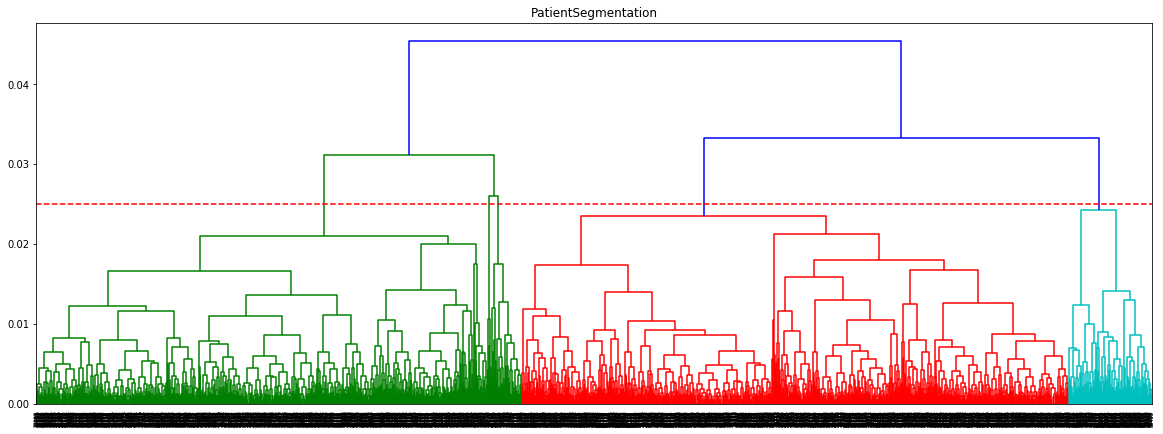

In [70]:
plt.figure(figsize=(20, 7))  
dendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.025, color='r', linestyle='--')
plt.show() 

<IPython.core.display.Javascript object>


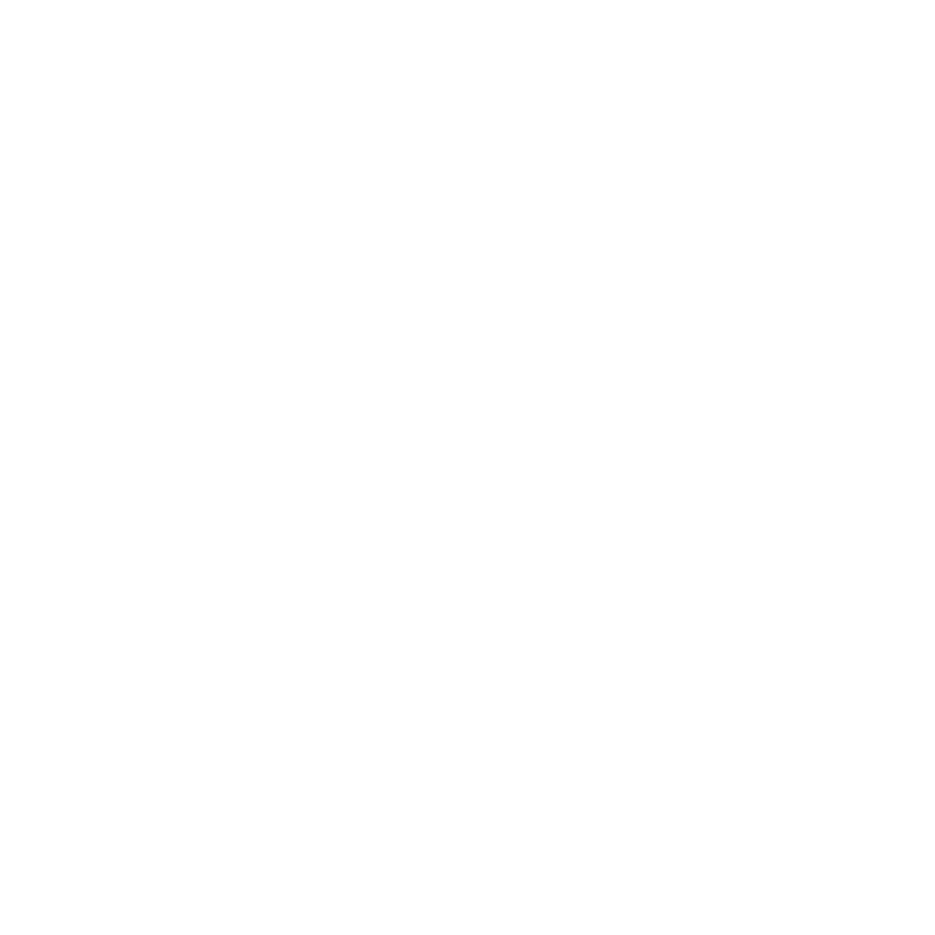

<IPython.core.display.Javascript object>


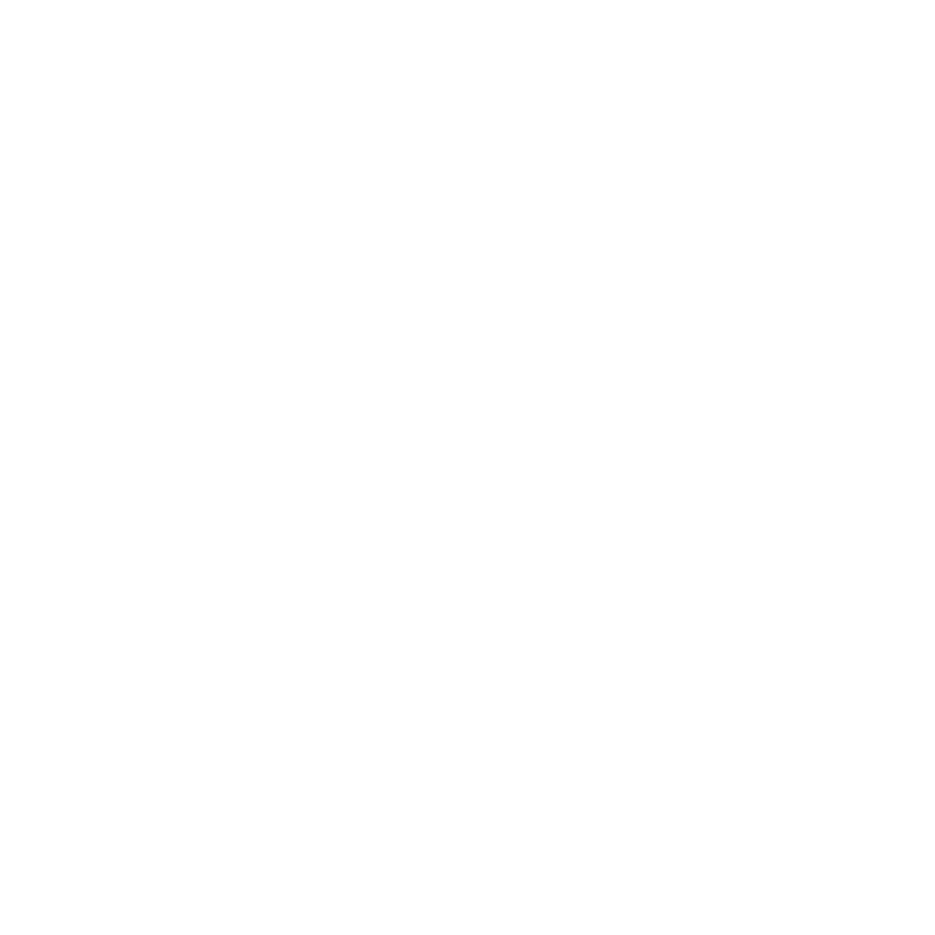

In [113]:
numClusters = 3
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

%matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=aggClustering.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


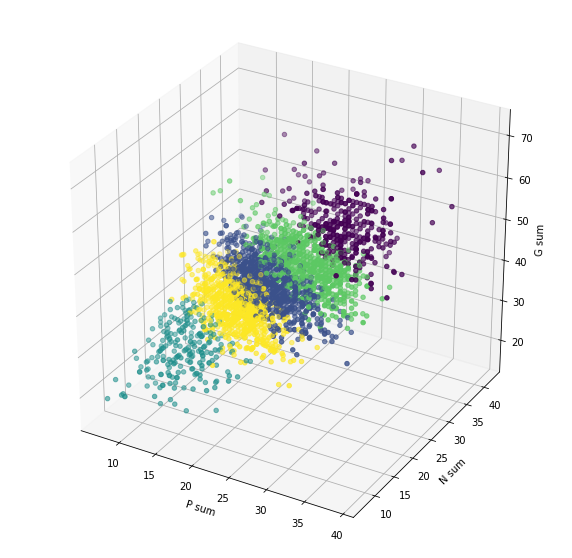

In [73]:
kMeansCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kMeansCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kMeansCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [150]:
#divide set into training and test data

#first, get all the possible attributes that we might want
studies = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Study_")== True])
X = ['TxGroup','RelativeVisitDay','PANSS_Total_lag_1']+studies
y = ['PANSS_Total']

#remove first visits as we cannot use that to make predictions (there is no previous data on it)
forecastDF = allSortedDF
forecastDF['RaterID'] = pd.factorize(forecastDF['RaterID'])[0]
forecastDF = forecastDF.loc[forecastDF.VisitDay != 0]

xSet = forecastDF[X]
ySet = forecastDF[y]

groups = forecastDF['PatientID']
patientsSplit = GroupKFold(n_splits=2)

#only do one split, so break after first iteration
for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = forecastDF.iloc[trainIndex]['PatientID']
    testGroups = forecastDF.iloc[testIndex]['PatientID']
    break
    

trainDF = pd.concat([xTrain,yTrain],axis=1)

In [131]:
#get ids of the users for whom we need to make predictions/classification
submissionIDs = pd.read_csv("sample_submission_PANSS.csv").PatientID

In [132]:
#make the prediction by first making the df for the features being used
extraCols = ['PANSS_Total']
submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
submissionXDF = submissionXDF.groupby('PatientID').last()
for col in extraCols:
    submissionXDF[col+"_lag_1"] = submissionXDF[col]
submissionXDF = submissionXDF.drop(extraCols,axis=1)

In [90]:
#try linear regression
testMSEs = list()
trainMSEs = list()
for degree in range(1,4,1):
    linearModel = linear_model.LinearRegression()
    #training MSE
    lrCV = cross_validate(linearModel,
                          PolynomialFeatures(degree).fit_transform(xTrain),
                          yTrain['PANSS_Total'],
                          scoring='neg_mean_squared_error',groups=trainGroups)
    
    trainMSEs.append(lrCV['train_score'])
    #Test MSE
    testMSEs.append(lrCV['test_score'])


Train MSE:44.113477156031784
Test MSE:51.31414112737617


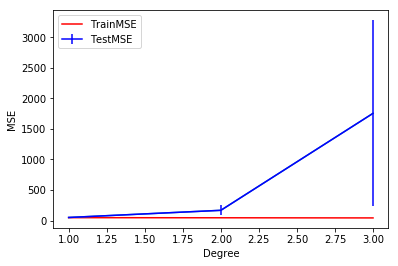

In [91]:
meanMSETrain = np.apply_along_axis(np.mean, 1, trainMSEs)
meanMSETest = np.apply_along_axis(np.mean, 1, testMSEs)
stdMSETest = np.apply_along_axis(stats.sem, 1, testMSEs)

xAxis = range(1,4,1)
plt.plot(xAxis,np.abs(meanMSETrain),c='red',label='TrainMSE')
plt.errorbar(xAxis,np.abs(meanMSETest),stdMSETest,c='blue',label='TestMSE')
plt.plot(xAxis,np.abs(meanMSETest))

plt.xlabel('Degree')
plt.ylabel('MSE')
plt.legend(loc='upper left')

print("Train MSE:"+str(np.min(np.abs(meanMSETrain))))
print("Test MSE:"+str(np.min(np.abs(meanMSETest))))

In [138]:
# Bagging approach
def bagging_regression_cv(
    degree,
    n_features_to_select,
    max_leaf_nodes,
    n_estimators):
    
    np.random.seed(5)
    baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(max_leaf_nodes))

    baggingModelReg = Pipeline([
      ('transformation', PolynomialFeatures(degree=int(degree))),
      ('feature_selection', RFE(baseModel,n_features_to_select=int(n_features_to_select))),
      ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(n_estimators)))
    ])
    
    #run CV on pipeline
    scores = cross_val_score(baggingModelReg, 
                            xTrain,
                            yTrain, 
                            cv=4,
                            scoring='neg_mean_squared_error',
                            groups=trainGroups)
    return scores.mean()
    
params={'degree':(1,3),
        'n_features_to_select':(1,32),
        'max_leaf_nodes':(2,64),
        'n_estimators':(10,3000)}

baggOptimizerReg = BayesianOptimization(f=bagging_regression_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerReg.maximize(n_iter=10)


|   iter    |  target   |  degree   | max_le... | n_esti... | n_feat... |
-------------------------------------------------------------------------


In [139]:
print(baggOptimizerReg.max)


{'target': -53.73803480090049, 'params': {'degree': 1.3830389007577846, 'max_leaf_nodes': 40.57074380446957, 'n_estimators': 1318.8059396312724, 'n_features_to_select': 25.346116095126845}}


In [151]:

np.random.seed(5)
baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(baggOptimizerReg.max['params']['max_leaf_nodes']))

baggingModelReg = Pipeline([
  ('transformation', PolynomialFeatures(degree=int(baggOptimizerReg.max['params']['degree']))),
  ('feature_selection', RFE(baseModel,n_features_to_select=int(baggOptimizerReg.max['params']['n_features_to_select']))),
  ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(baggOptimizerReg.max['params']['n_estimators'])))
]) 

baggModelRegFit = baggingModelReg.fit(xTrain,yTrain)

yPredTrainBagReg = baggingModelReg.predict(xTrain)
yPredTestBagReg = baggingModelReg.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrainBagReg,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTestBagReg,np.asarray(yTest.PANSS_Total))))


Train MSE:50.28329900979922
Test MSE:49.100551470712574


In [149]:
predictions = baggingModelReg.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_bagg_decision_tree_Grouped_remove_firsts.csv",index=False)

In [141]:
#hyperparameter tuning for xgb 
def xgb_cv(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBRegressor(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='reg:squarederror',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate).fit(xTrain,yTrain)
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_mean_squared_error',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}
optimizer = BayesianOptimization(f=xgb_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  2        | -59.25    |  0.3461   |  0.008039 |  7.749    |  10.13    |  2.431e+0 |  0.5459   |
|  3        | -55.1     |  0.7083   |  0.007156 |  4.222    |  7.928    |  3.012e+0 |  0.1123   |
|  5        | -55.08    |  0.9305   |  0.006549 |  4.383    |  9.521    |  2.267e+0 |  0.6056   |
|  6        | -55.06    |  0.9319   |  0.006099 |  4.545    |  9.092    |  2.268e+0 |  0.5171   |
|  7        | -54.11    |  0.9791   |  0.00655  |  2.392    |  5.935    |  2.285e+0 |  0.2963   |
|  10       | -54.1     |  0.9808   |  0.006563 |  2.383    |  5.94     |  2.285e+0 |  0.2968   |


In [142]:
print(optimizer.max)

{'target': -54.097234613540635, 'params': {'colsample_bytree': 0.9808102827896594, 'learning_rate': 0.006562561982421833, 'max_depth': 2.382564839446771, 'min_child_weight': 5.940311901269824, 'num_estimators': 2285.1996956742832, 'subsample': 0.2967948074053526}}


In [152]:
#train xgb model
max_depth = int(2.383)
min_child_weight = 5.94
subsample = 0.2968
colsample_bytree = 0.9808 
objective = 'reg:squarederror'
num_estimators = int(2285)
learning_rate = 0.006563

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict(xTrain)
yPredTest = boostModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))

Train MSE:50.4281984940044
Test MSE:48.22839290604808


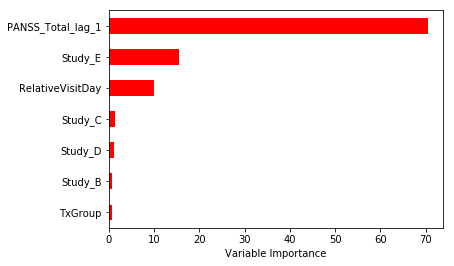

In [147]:
%matplotlib inline
Importance = pd.DataFrame({'Importance':boostModelFit.feature_importances_*100}, index=xTrain.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [148]:
predictions = boostModel.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_XGB_Grouped_remove_firsts.csv",index=False)

# Classification


In [107]:
def checkMultipleValuesShared(df,group,column):
    print(group+":"+str(sum(df.groupby([group])[column].unique().apply(lambda x:1 if len(x) > 1 else 0))>0))

# check if possible to have multiple studies with same values. 
checkMultipleValuesShared(allSortedDF,'Country','Study')
checkMultipleValuesShared(allSortedDF,'SiteID','Study')
checkMultipleValuesShared(allSortedDF,'PatientID','Study')
checkMultipleValuesShared(allSortedDF,'RaterID','Study')


Country:True
SiteID:False
PatientID:False
RaterID:False


In [74]:
#divide set into training and test data

#first, get all the possible attributes that we might want

# since each patient,site,Rater is unique to the study, cannot use those as features

countries = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Country_")== True])
X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total',
     'PANSS_Total_diff_1_lag_1','Ns_lag_1','Gs_lag_1','Ns','Gs']
# X = ['VisitDay','RelativeVisitDay']
y = ['LeadStatus']

#fill na for lags
allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
# let values of nan for lag of diff (occurs when visit day= 0), equal 0
allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1'].fillna(0)
allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1'].fillna(allSortedDF.Gs)
allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1'].fillna(allSortedDF.Ns)

groupVar = 'PatientID'

classificationDF = allSortedDF.loc[allSortedDF['Study_E'] == 0][X+y+[groupVar]]
resultDF = allSortedDF.loc[allSortedDF['Study_E'] == 1][X+['AssessmentiD']+[groupVar]]

xSet = classificationDF[X]
ySet = classificationDF[y]

from sklearn.model_selection import GroupKFold

# need to do groupfold CV as we are creating probs for patients never seen before
groups = classificationDF[groupVar]
patientsSplit = GroupKFold(n_splits=4)

for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = classificationDF.iloc[trainIndex][groupVar]
    testGroups = classificationDF.iloc[testIndex][groupVar]
    break

Text(0, 0.5, 'VisitDay')

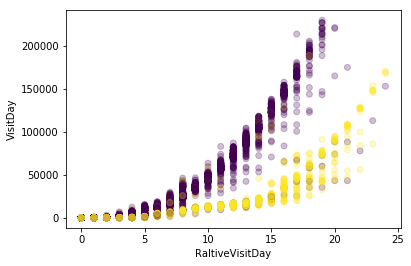

In [43]:
# %matplotlib inline
#purple = pass,yellow = flagged/assigned
plt.scatter(xTrain.RelativeVisitDay,np.power(xTrain.VisitDay,2),c=list(yTrain.LeadStatus),alpha=0.25)
plt.xlabel("RaltiveVisitDay")
plt.ylabel("VisitDay")

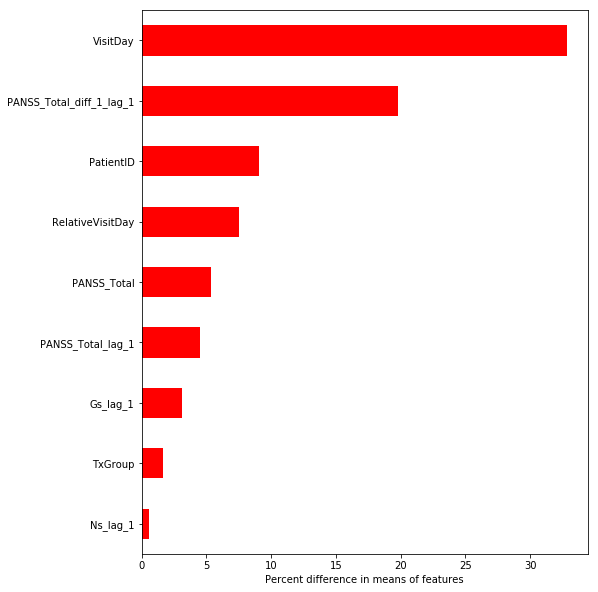

In [91]:
# visualize the difference in means of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
means = classificationDF.groupby(['LeadStatus']).mean().transpose()
means['diff'] = 100*(means[0.0]-means[1.0])/means[0.0]

Importance = pd.DataFrame({'Importance':np.abs(means['diff'])}, index=means.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in means of features')

plt.gca().legend_ = None


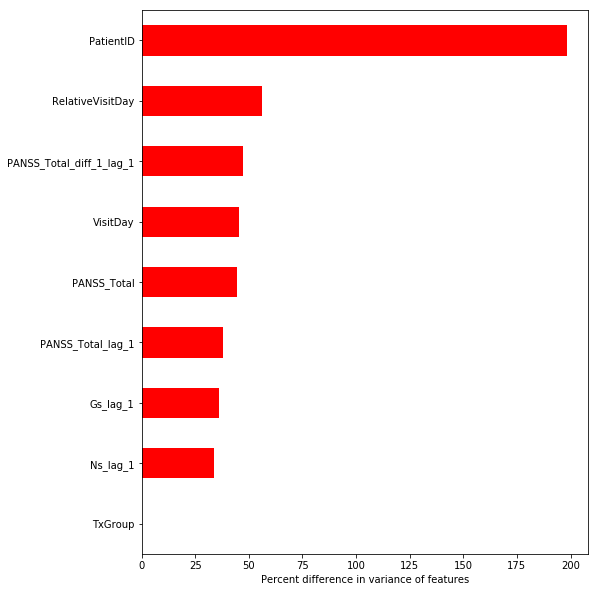

In [92]:
# visualize the difference in vars of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
variances = classificationDF.groupby(['LeadStatus']).var().transpose()
variances['diff'] = 100*(variances[0.0]-variances[1.0])/variances[0.0]

Importance = pd.DataFrame({'Importance':np.abs(variances['diff'])}, index=variances.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in variance of features')

plt.gca().legend_ = None

In [97]:
from sklearn.metrics import log_loss

testMSEs = []
trainMSEs = []
for k in range(30,200,5):
    # try KNN
    knnModel = KNeighborsClassifier(k)
#     knnModel.fit(xTrain,yTrain)
    knnCV = cross_validate(knnModel,xTrain,yTrain['LeadStatus'],scoring='neg_log_loss',groups=trainGroups)
#     #only get probs for class=1, i.e. notPassed
#     yPredTrain = knnModel.predict_proba(xTrain)[:,1]
#     trainMSEs.append(brier_score_loss(yTrain.LeadStatus,yPredTrain))
    
#     yPredTest = knnModel.predict_proba(xTest)[:,1]
    trainMSEs.append(knnCV['train_score'])
    testMSEs.append(knnCV['test_score'])

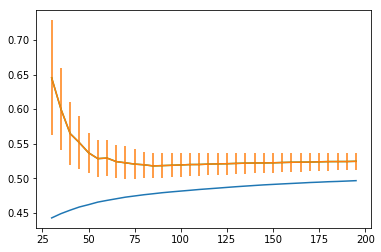

In [98]:
meanMSETrain = np.apply_along_axis(np.mean, 1, trainMSEs)
meanMSETest = np.apply_along_axis(np.mean, 1, testMSEs)
stdMSETest = np.apply_along_axis(stats.sem, 1, testMSEs)

xAxis = range(30,200,5)
plt.plot(xAxis,np.abs(meanMSETrain))
plt.errorbar(xAxis,np.abs(meanMSETest),stdMSETest)
plt.plot(xAxis,np.abs(meanMSETest))


### Tune and fit for XGB model

In [144]:
# try gradient boosting
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv_classifier(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBClassifier(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='binary:logistic',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate,
                random_state=123).fit(xTrain,yTrain)
    
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}

optimizer = BayesianOptimization(f=xgb_cv_classifier,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)



|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  10       | -0.4407   |  0.6905   |  0.004759 |  2.094    |  4.135    |  3.915e+0 |  0.8824   |
|  13       | -0.4392   |  0.6073   |  0.005899 |  2.126    |  4.08     |  3.362e+0 |  0.8598   |


In [145]:
# print(optimizer.max)

{'target': -0.43917249932970964, 'params': {'colsample_bytree': 0.6073111561918005, 'learning_rate': 0.00589865212311415, 'max_depth': 2.1255364411201776, 'min_child_weight': 4.080382214025044, 'num_estimators': 3362.473369214361, 'subsample': 0.8598211980345092}}


In [201]:
max_depth = int(optimizer.max['params']['max_depth'])
min_child_weight = optimizer.max['params']['min_child_weight']
subsample = optimizer.max['params']['subsample']
colsample_bytree = optimizer.max['params']['colsample_bytree']
objective = 'binary:logistic'
num_estimators = int(optimizer.max['params']['num_estimators'])
learning_rate = optimizer.max['params']['learning_rate'] 

boostModel = xgb.XGBClassifier(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate,
                random_state=1234)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict_proba(xTrain)[:,1]
yPredTest = boostModelFit.predict_proba(xTest)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrain)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTest)))

Train Log loss:0.3867989217112141
Test Log loss:0.40505966685806255


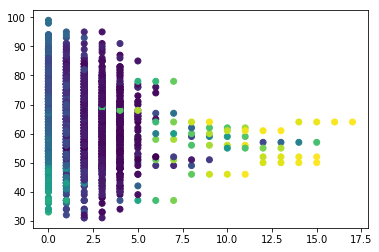

In [202]:
plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=boostModel.predict_proba(
    resultDF.drop(['AssessmentiD',groupVar],axis=1))[:,1])


### tuning and predictions for bagging - logistic regression

In [78]:
def bagging_cv_classifier_Logit(
    n_estimators,
    max_features,
    degree,C):

    dataSet = PolynomialFeatures(degree=int(degree)).fit_transform(xTrain)
    baseEstimator = linear_model.LogisticRegression(C=C)
    baggingClassifier = BaggingClassifier(baseEstimator,
                                          n_estimators=int(n_estimators),
                                          max_features=max_features,
                                          random_state=1234).fit(dataSet,yTrain)
    
    cval = cross_val_score(baggingClassifier,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_features':(0.1,1.0),
        'n_estimators':(1,50),
        'degree':(1,3.1),
        'C':(0.001,1)}

baggOptimizerLogit = BayesianOptimization(f=bagging_cv_classifier_Logit,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerLogit.maximize(n_iter=10)

|   iter    |  target   |     C     |  degree   | max_fe... | n_esti... |
-------------------------------------------------------------------------
|  5        | -0.4706   |  0.5036   |  1.029    |  0.7955   |  44.25    |
|  6        | -0.4669   |  0.001    |  1.0      |  1.0      |  1.0      |
|  8        | -0.4669   |  0.001    |  1.0      |  1.0      |  12.7     |
|  14       | -0.4664   |  0.001    |  1.0      |  1.0      |  6.108    |


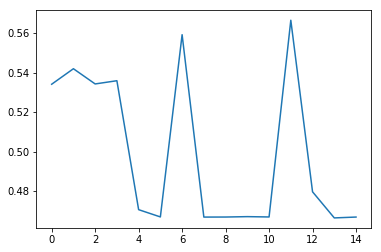

In [79]:
iterations=[]
degrees=[]
for iter in baggOptimizerLogit.res:
    iterations.append(np.abs(iter['target']))
    degrees.append(iter['params']['degree'])
plt.plot(range(len(iterations)),iterations)

In [99]:
# print(baggOptimizerLogit.max)

{'target': -0.4664445185677608, 'params': {'C': 0.001, 'degree': 1.0, 'max_features': 1.0, 'n_estimators': 6.107766810957897}}


In [97]:


degree = int(baggOptimizerLogit.max['params']['degree'])
trainDataBag=PolynomialFeatures(degree).fit_transform(xTrain)
testDataBag=PolynomialFeatures(degree).fit_transform(xTest)

C = baggOptimizerLogit.max['params']['C']
baggingClassifierLogit = BaggingClassifier(base_estimator=linear_model.LogisticRegression(C=C),
                                      n_estimators=int(baggOptimizerLogit.max['params']['n_estimators']),
                                      max_features=baggOptimizerLogit.max['params']['max_features'],
                                      random_state=1234)
baggingClassifierLogitFit = baggingClassifierLogit.fit(trainDataBag,yTrain)

yPredTrainBagLogit = baggingClassifierLogit.predict_proba(trainDataBag)[:,1]
yPredTestBagLogit = baggingClassifierLogit.predict_proba(testDataBag)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrainBagLogit)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTestBagLogit)))

{'target': -0.4664445185677608, 'params': {'C': 0.001, 'degree': 1.0, 'max_features': 1.0, 'n_estimators': 6.107766810957897}}
Train Log loss:0.43036994783805466
Test Log loss:0.4345202861128038


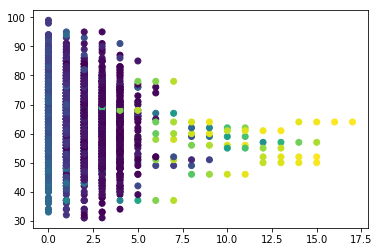

In [98]:
resultDataBag = PolynomialFeatures(degree).fit_transform(resultDF.drop(['AssessmentiD',groupVar],axis=1))
plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=baggingClassifierLogitFit.predict_proba(
    resultDataBag)[:,1])


### Prediction of Logit with poly=3

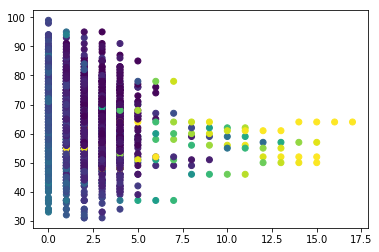

In [203]:
logitModel = linear_model.LogisticRegression().fit(PolynomialFeatures(3).fit_transform(xTrain),yTrain)

plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=logitModel.predict_proba(PolynomialFeatures(3).fit_transform(
    resultDF.drop(['AssessmentiD','PatientID'],axis=1)))[:,1])


### Submission forming For classification

In [31]:
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (knnLogitAverage)
submissionBC.to_csv("classification_submissions/classification_submit_Logit.csv",index=False)

In [114]:

binaryClassification = boostModelFit.predict_proba(resultDF.drop(['AssessmentiD',binaryClassification = baggingClassifierFit.predict_proba(resultDF.drop(['AssessmentiD',groupVar],axis=1))[:,1]
],axis=1))[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_XGB.csv",index=False)

In [88]:

binaryClassification = baggingClassifierLogitFit.predict_proba(resultDataBag)[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_bag_logit.csv",index=False)

### References
1. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
2. https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
3. https://github.com/fmfn/BayesianOptimization
